# Notebook 31: Core properties interpolation

In this notebook we hope to find out CHE is efficient at producing a pile-up of $35\,\mathrm{M}_\odot$ BHs under some particular setting for our wind model.

In [1]:
# nb_id is used to identify this notebook's output files (i.e., figures) if there are any
# it should match the first two digits in the notebook's title
nb_id = 31

## Imports

In [2]:
from pathlib import Path
from math import isnan

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, TwoSlopeNorm, to_rgba
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import astropy.units as u
import astropy.constants as ct
from scipy.signal import find_peaks

import mesa_reader as mr
import mesaPlot as mp
import tulips as tp

import sys
sys.path.append('..')
from src.star import fix_unit, eggleton_rl1_radius, a_from_p, p_from_a, marchant_l2_radius

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [3]:
CODE_ROOT = Path('/mnt/home/ldesa/repos/cher')
DATA_ROOT = Path('/mnt/ceph/users/ldesa/mesa_che_grids')

In [4]:
PROJECT_FOLDER = DATA_ROOT/'sse_carbon'
FIGURE_FOLDER = Path(f'./output/nb{nb_id}/figures')
FIGURE_FOLDER.mkdir(parents=True, exist_ok=True)

In [5]:
plt.style.use('./plotstyle.mplstyle')

## Definitions

### Constants

### Utilities

In [6]:
def savefig(fig, fname):
    """Saves png, pdf and eps figure files to a nb-specific folder."""
    fname = f'nb{nb_id}_{fname}'
    plt.savefig(FIGURE_FOLDER/(fname+'.png'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.pdf'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.eps'), bbox_inches='tight')

In [7]:
def normarr(arr):
    return (arr-min(arr))/(max(arr)-min(arr))

In [8]:
def get_model_folder(model_id, verbose=True):
    """Finds model folder given its id."""
    matches = list(PROJECT_FOLDER.glob(f'{model_id}_*'))
    
    if len(matches) > 1:
        if verbose:
            print('\n'.join((
                f'Multiple matches for id {model_id} found in {PROJECT_FOLDER}:',
                *[str(match) for match in matches]
            )))
        return
    elif len(matches) != 0:
        match = matches[0]
        if verbose:
            print(f'Found match {match}')
        return match
    else:
        if verbose:
            print(f'No matches found in {PROJECT_FOLDER}')
        return           

In [9]:
def get_model_dict(grid_folder):
    """Given a model folder, loads the paths of specific stars into a 
    m1, p_orb dictionary."""
    d = dict()
    for model_folder in grid_folder.glob('m*_w*'):
        if model_folder.suffix == '.log':
            continue
        m, w = model_folder.name.replace('d', 'e').split('_')        
        m = f'{float(m.lstrip("m")):.1f}'
        w = float(w.lstrip('w'))
        p = 2*np.pi / w / (60*60*24)
        p = f'{p:.2f}'
        if m not in d.keys():
            d[m] = dict()
        d[m][p] = model_folder
    return d

In [10]:
def mesareader_operator(expression):
    """Converts strings into operations between mesareader columns.
    
    Supports summation, subtraction, multiplication, division and exp10."""
    operations = ['+', '-', '*', '/', '^', 'E', '(', ')', ',']
    
    mr_expression = ''
    attr = ''
    char_i = 0
    while char_i < len(expression):
        char = expression[char_i]
        if char not in operations:
            mr_expression += f'h.__getattr__("{char}'
        else:
            if char == '^':
                char = '10**'
            elif char == 'E':
                char = 'gamma_e('
            mr_expression += f'{char}h.__getattr__("'
        char_i += 1
        char = expression[char_i]
        while char not in operations+['']:
            attr += char
            char_i += 1
            try:
                char = expression[char_i]
            except IndexError:
                char = ''
        if char == '^':
            char = '10**'
        elif char == 'E':
                char = 'gamma_e('
        attr = f'{attr}"){char}'
        mr_expression += attr
        attr = ''
        char_i += 1
            
    return mr_expression


### Plotting

In [11]:
def history_plot(ax, model_dict_list, model_styles, model_labels, x, y, invert_xaxis, invert_yaxis, title=False,
                 label_period=True):
    """2D line plot for all m1, p_orb combinations from a given model.
    
    Assumes a single m1 per dict.
    """
    
    #base_dict = model_dict_list[0]
    #all_paths = [base_dict[k1][k2] for k1 in base_dict.keys() for k2 in base_dict[k1].keys()] 
    
    all_periods = []
    for dict_ in model_dict_list:
        for k1 in dict_.keys():
            for k2 in dict_[k1].keys():
                all_periods.append(k2)
    all_periods = np.unique(all_periods)
    all_periods = all_periods[np.argsort([float(p) for p in all_periods])]
    
    period_color_dict = {}
    for i, p in enumerate(all_periods):
        period_color_dict[p] = cm.jet(i/len(all_periods))
    
    handles = []
    for p_key in all_periods:
        p = float(p_key)
        c = period_color_dict[p_key]
        
        if label_period:
            label = f'${p:.2f}\\,\\mathrm{{d}}$'
        else:
            label = None
        handles.append(Line2D([], [], ls='-', color=c, label=label))
               
        for dict_, ls in zip(model_dict_list, model_styles):
            dict_ = dict_[list(dict_.keys())[0]]
            try:
                model_path = dict_[p_key]
                h = mr.MesaData(str(model_path/'LOGS/history.data'))
            except:
                print(f'Model {model_path} failed to load.')
                continue
            else:
                x_data = eval(mesareader_operator(x))
                y_data = eval(mesareader_operator(y))
                ax.plot(x_data, y_data, ls=ls, color=c, lw=1)
                
    if invert_xaxis:
        ax.invert_xaxis()
    if invert_yaxis:
        ax.invert_yaxis()
    
    if title:
        ax.set_title(model_labels[0], fontsize=20)
    #else:
        #for ls, label in zip(model_styles, model_labels):
         #   handles.append(Line2D([], [], color='k', ls=ls, label=label))
    if label_period:
        ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
    
    return ax

### Final properties

In [12]:
def get_core_mass_spin_w(logs, iso):
    central_iso_arr = [logs.profile_data(profile_number=n).__getattr__(iso)[-1] for n in logs.profile_numbers]
    max_iso_i = np.argmax(central_iso_arr)
    core_prof = logs.profile_data(profile_number=logs.profile_numbers[max_iso_i])
    core_edge_index = np.where(np.abs(core_prof.__getattr__(iso)-core_prof.__getattr__(iso)[-1]) <= 0.01)[0][0]
    core_mass = core_prof.mass[core_edge_index]
    core_am = 10**core_prof.log_J_inside[core_edge_index]
    core_w = core_prof.omega[core_edge_index]
    core_spin = (ct.c.cgs * core_am * u.g*u.cm**2/u.s / (ct.G.cgs * (core_mass * ct.M_sun.cgs)**2 )).to(u.dimensionless_unscaled).value
    return core_mass, core_spin, core_w

# Analysis

For now we only have models with mass variations, where all other settings fixed. These are $\delta_\mathrm{mesh}=1$, $Z=\mathrm{Z}_\odot/10$, $Y_0=0.4$ and $\delta Y=0.3$.

In [13]:
model_ids = np.arange(1, 21, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/001_md1_m20_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/002_md1_m30_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/003_md1_m40_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/004_md1_m50_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/005_md1_m60_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/006_md1_m70_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/007_md1_m80_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/008_md1_m90_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/009_md1_m100_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/010_md1_m110_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/011_md1_m120_zsund

Let's check the stellar models available.

In [14]:
print('Available models:')
for i in range(len(model_ids)):
    print(f'\t{model_folders[i]}:')
    keys1 = list(model_dicts[i].keys())
    keys1 = np.array(keys1)[np.argsort([float(key) for key in keys1])]
    for key1 in keys1:
        keys2 = list(model_dicts[i][key1].keys())
        keys2 = np.array(keys2)[np.argsort([float(key) for key in keys2])]
        print(f'\t\t(m1/msun) {key1}:')
        for key2 in keys2:
            print(f'\t\t\t(p_orb/d) {key2}')

Available models:
	/mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/001_md1_m20_zsundiv10_04y0_03dy:
		(m1/msun) 20.0:
			(p_orb/d) 0.35
			(p_orb/d) 0.40
			(p_orb/d) 0.45
			(p_orb/d) 0.50
			(p_orb/d) 0.55
			(p_orb/d) 0.60
			(p_orb/d) 0.65
			(p_orb/d) 0.70
			(p_orb/d) 0.75
			(p_orb/d) 0.80
			(p_orb/d) 0.85
			(p_orb/d) 0.90
			(p_orb/d) 1.00
			(p_orb/d) 1.10
			(p_orb/d) 1.20
			(p_orb/d) 1.30
			(p_orb/d) 1.40
			(p_orb/d) 1.50
			(p_orb/d) 1.60
			(p_orb/d) 1.70
			(p_orb/d) 1.80
			(p_orb/d) 1.90
			(p_orb/d) 2.00
			(p_orb/d) 2.10
			(p_orb/d) 2.20
			(p_orb/d) 2.30
			(p_orb/d) 2.40
			(p_orb/d) 2.50
			(p_orb/d) 2.60
			(p_orb/d) 2.80
			(p_orb/d) 3.00
			(p_orb/d) 3.20
			(p_orb/d) 3.40
			(p_orb/d) 3.60
			(p_orb/d) 3.80
			(p_orb/d) 4.00
	/mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/002_md1_m30_zsundiv10_04y0_03dy:
		(m1/msun) 30.0:
			(p_orb/d) 0.35
			(p_orb/d) 0.40
			(p_orb/d) 0.45
			(p_orb/d) 0.50
			(p_orb/d) 0.55
			(p_orb/d) 0.60
			(p_orb/d) 0.65
			(p_or

In [15]:
h = mr.MesaData(str(model_dicts[19]['300.0']['1.60']/'LOGS/history.data'))

Text(0.9, 0.9, '$m_0=300\\,\\mathrm{M}_\\odot$')

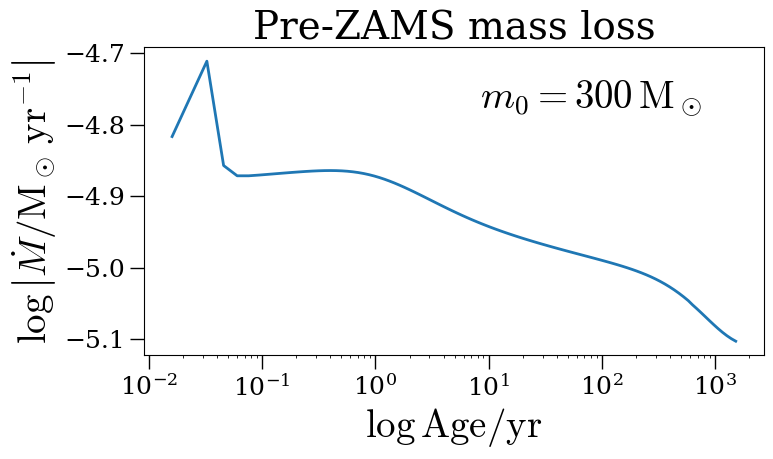

In [16]:
fig, ax = plt.subplots(figsize=(8, 4))
zams_i = np.where(h.surf_avg_omega>0)[0][0]
ax.plot(h.star_age[:zams_i], h.log_abs_mdot[:zams_i])
ax.set_xscale('log')
ax.set_ylabel('$\\log\\left|\\dot{M}/\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1}\\right|$')
ax.set_xlabel('$\\log\\mathrm{Age}/\\mathrm{yr}$')
ax.set_title('Pre-ZAMS mass loss')
ax.text(0.9, 0.9, '$m_0=300\\,\\mathrm{M}_\\odot$', ha='right', va='top', transform=ax.transAxes)

In [17]:
h = mr.MesaData(str(model_dicts[0]['20.0']['0.35']/'LOGS/history.data'))

Text(0.9, 0.9, '$m_0=20\\,\\mathrm{M}_\\odot$')

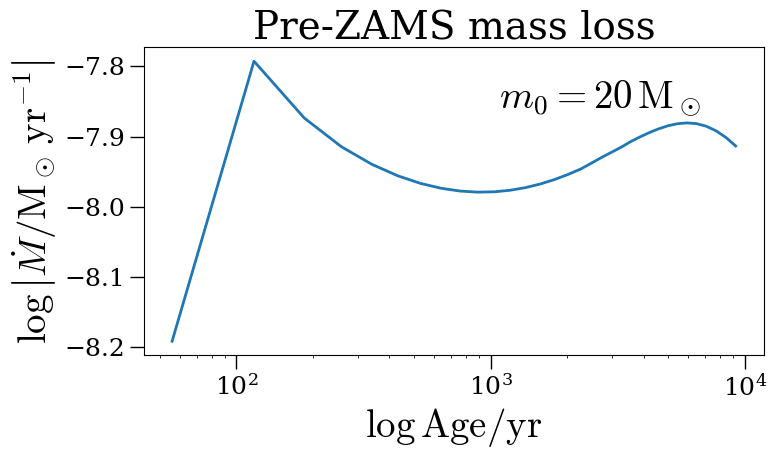

In [18]:
fig, ax = plt.subplots(figsize=(8, 4))
zams_i = np.where(h.surf_avg_omega>0)[0][0]
ax.plot(h.star_age[:zams_i], h.log_abs_mdot[:zams_i])
ax.set_xscale('log')
ax.set_ylabel('$\\log\\left|\\dot{M}/\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1}\\right|$')
ax.set_xlabel('$\\log\\mathrm{Age}/\\mathrm{yr}$')
ax.set_title('Pre-ZAMS mass loss')
ax.text(0.9, 0.9, '$m_0=20\\,\\mathrm{M}_\\odot$', ha='right', va='top', transform=ax.transAxes)

## Core properties

In [19]:
def is_of(r, m, p, q=1, kind='RL'):
    a = a_from_p(p, m, q)
    if kind == 'merger':
        of_a = a.to(u.Rsun).value
    elif kind == 'RL':
        of_a = eggleton_rl1_radius(a, q).to(u.Rsun).value
    elif kind == 'L2':
        of_a = marchant_l2_radius(a, q).to(u.Rsun).value
    elif kind == 'none':
        of_a = np.inf
    else:
        raise ValueError(f'kind {kind} not recognized')
    if of_a <= r:
        isof = True
    else:
        isof = False

    return isof

In [20]:
# Select models
models_to_plot = np.arange(0, len(model_dicts), 1)
model_dict_list = model_dicts[models_to_plot]
print(f'Loading {model_dict_list}')

# Collect periods
all_periods = []
for dict_ in model_dict_list:
    for k1 in dict_.keys():
        for k2 in dict_[k1].keys():
            all_periods.append(k2)
all_periods = np.unique(all_periods)
all_periods = all_periods[np.argsort([float(p) for p in all_periods])][1:]
print(all_periods)

Loading [{'20.0': {'2.40': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_w3.030d-05'), '0.85': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_w8.556d-05'), '1.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_w4.545d-05'), '0.70': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_w1.039d-04'), '0.75': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_w9.696d-05'), '2.30': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_w3.162d-05'), '1.70': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_w4.278d-05'), '1.10': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_w6.

In [21]:
#np.save(f'nb{nb_id}_p_plot_extended.npy', p_plot)
final_mass_array = np.load('00_enhanced_w_core_props.npy')

In [22]:
mass_guide_str = [list(dict_.keys())[0] for dict_ in model_dict_list]
mass_guide_float = np.array([float(m) for m in mass_guide_str])

period_guide_str = all_periods
period_guide_float = np.array([float(p) for p in period_guide_str])

In [23]:
from scipy.interpolate import interp1d

In [24]:
from math import nan

### Core mass plane

In [25]:
stage_index = dict(zams=6, prezams=7)

In [26]:
def mzams_p0_mcore_of_plot(ax, of_when, of_kind, min_mcore=20, max_mcore=50):    
    of_when_i = stage_index[of_when]
    handles = []
    for i, m_key in enumerate(mass_guide_str):
        c = cm.jet(i/len(mass_guide_str))
        handles.append(ax.scatter([], [], c=c, marker='o', label=m_key))
        m_zams = float(m_key)
        
        #che_mask = np.array(final_mass_array[:,i,9], bool)
        pp = period_guide_float#[che_mask]
        mm = final_mass_array[:,i,0]#[che_mask]
        rr = final_mass_array[:,i,of_when_i]#[che_mask]
        is_che = np.array(final_mass_array[:,i,9], bool)
        is_crit = np.array(final_mass_array[:,i,8], bool)
        
        for p, r, m_core, ische, iscrit in zip(pp, rr, mm, is_che, is_crit):
            if iscrit:
                marker = 'x'
                color = 'k'
            elif not ische:
                marker = '+'
                color = 'k'
            else:
                marker = 'o'
                color = cm.jet_r((np.log10(m_core)-np.log10(min_mcore))/(np.log10(max_mcore)-np.log10(min_mcore)))
            isof = is_of(r, m_zams, p, 1, kind=of_kind)
            if isof:
                alpha = 0.3
            else:
                alpha = 1.0
            ax.scatter(m_zams, p, marker=marker, color=color, zorder=1, s=30, alpha=alpha)
    return ax, handles

In [27]:
def p0_mcore_mzams_of_plot(ax, of_when, of_kind):
    of_when_i = stage_index[of_when]
    handles = []
    for i, m_key in enumerate(mass_guide_str):
        c = cm.jet(i/len(mass_guide_str))
        handles.append(ax.scatter([], [], c=c, marker='o', label=m_key))
        m_zams = float(m_key)
        
        che_mask = np.array(final_mass_array[:,i,9], bool)
        pp = period_guide_float[che_mask]
        mm = final_mass_array[:,i,0][che_mask]
        rr = final_mass_array[:,i,of_when_i][che_mask]
            
        for p, r, m_core in zip(pp, rr, mm):
            isof = is_of(r, m_zams, p, 1, kind=of_kind)
            if isof:
                ax.scatter(p, m_core, marker='x', color=c, zorder=1, s=30, alpha=0.3)
                pass
            else:
                ax.scatter(p, m_core, marker='o', color=c, zorder=1, s=30)
    return ax, handles

/tmp/ipykernel_427130/1681239613.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handles.append(ax.scatter([], [], c=c, marker='o', label=m_key))


Text(1, 0.5, 'Before ZAMS')

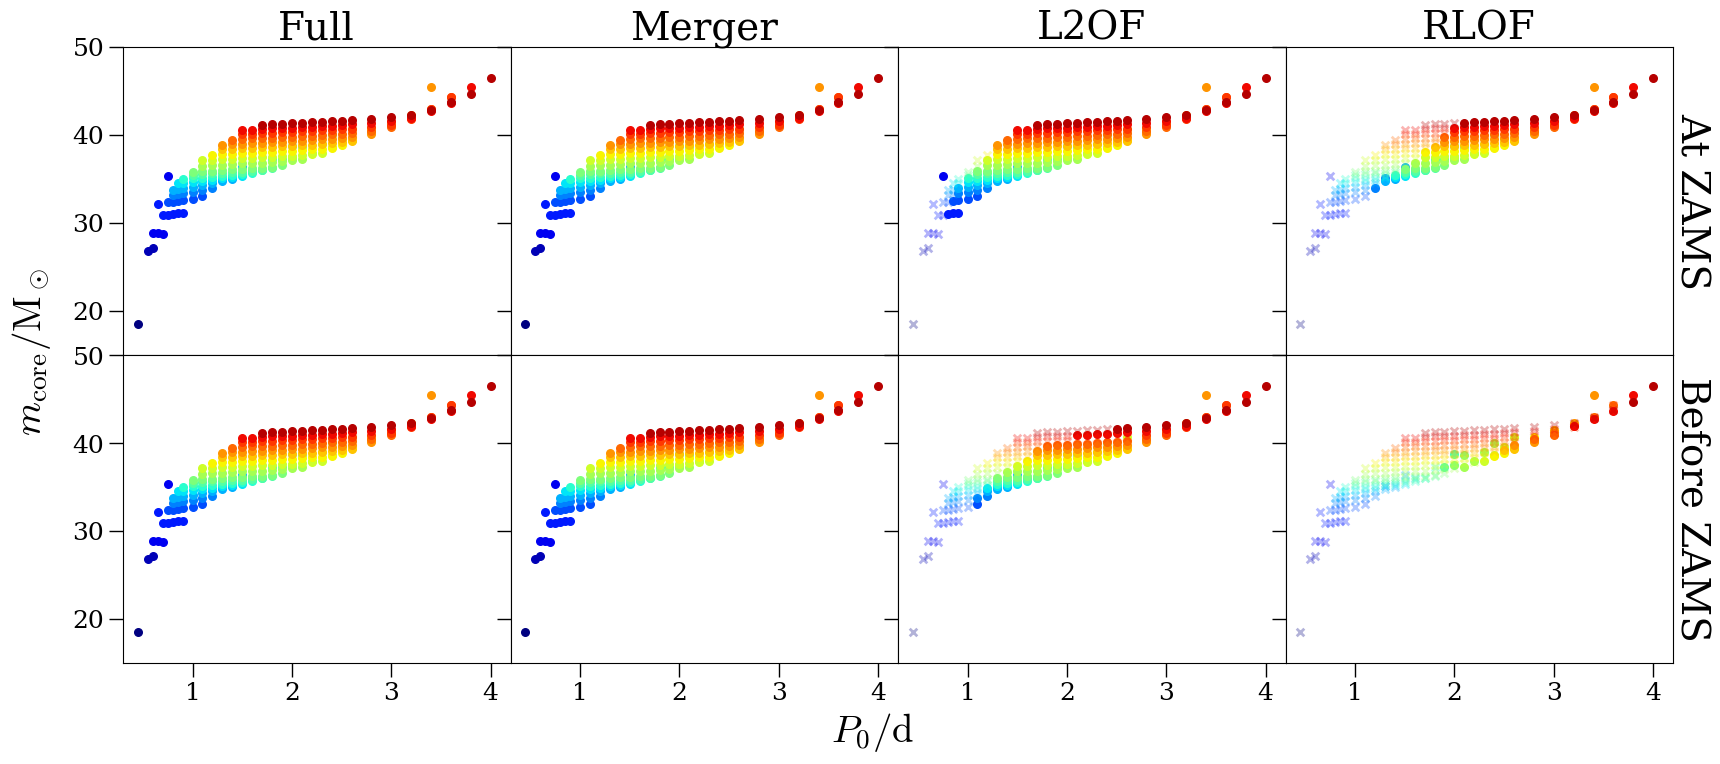

In [28]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)
plot_ps = np.linspace(0, 4, 100)

# AT ZAMS
of_when = 'zams'

of_kind = 'none'
ax = axes[0, 0]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)
ax.set_title('Full')                

of_kind = 'merger'
ax = axes[0, 1]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)
ax.set_title('Merger')                

of_kind = 'L2'
ax = axes[0, 2]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)
ax.set_title('L2OF')                

of_kind = 'RL'
ax = axes[0, 3]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)
ax.set_title('RLOF')                

# AT ZAMS
of_when = 'prezams'

of_kind = 'none'
ax = axes[1, 0]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)

of_kind = 'merger'
ax = axes[1, 1]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)

of_kind = 'L2'
ax = axes[1, 2]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)

of_kind = 'RL'
ax = axes[1, 3]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)
           
ax.set_ylim(15, 50)
ax.set_xlim(0.3, 4.2)

fig.text(0.09, 0.5, '$m_\\mathrm{core}/\\mathrm{M}_\\odot$', rotation=90, ha='right', va='center')
fig.text(0.5, 0.05, '$P_0/\\mathrm{d}$', ha='center', va='top')
axes[0, 3].text(1, 0.5, 'At ZAMS', rotation=-90, ha='left', va='center', transform=axes[0, 3].transAxes)
axes[1, 3].text(1, 0.5, 'Before ZAMS', rotation=-90, ha='left', va='center', transform=axes[1, 3].transAxes)

#ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=2, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')


#savefig(fig, 'pzams_mcore_data')

/tmp/ipykernel_427130/1681239613.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handles.append(ax.scatter([], [], c=c, marker='o', label=m_key))


Text(1, 0.5, 'Before ZAMS')

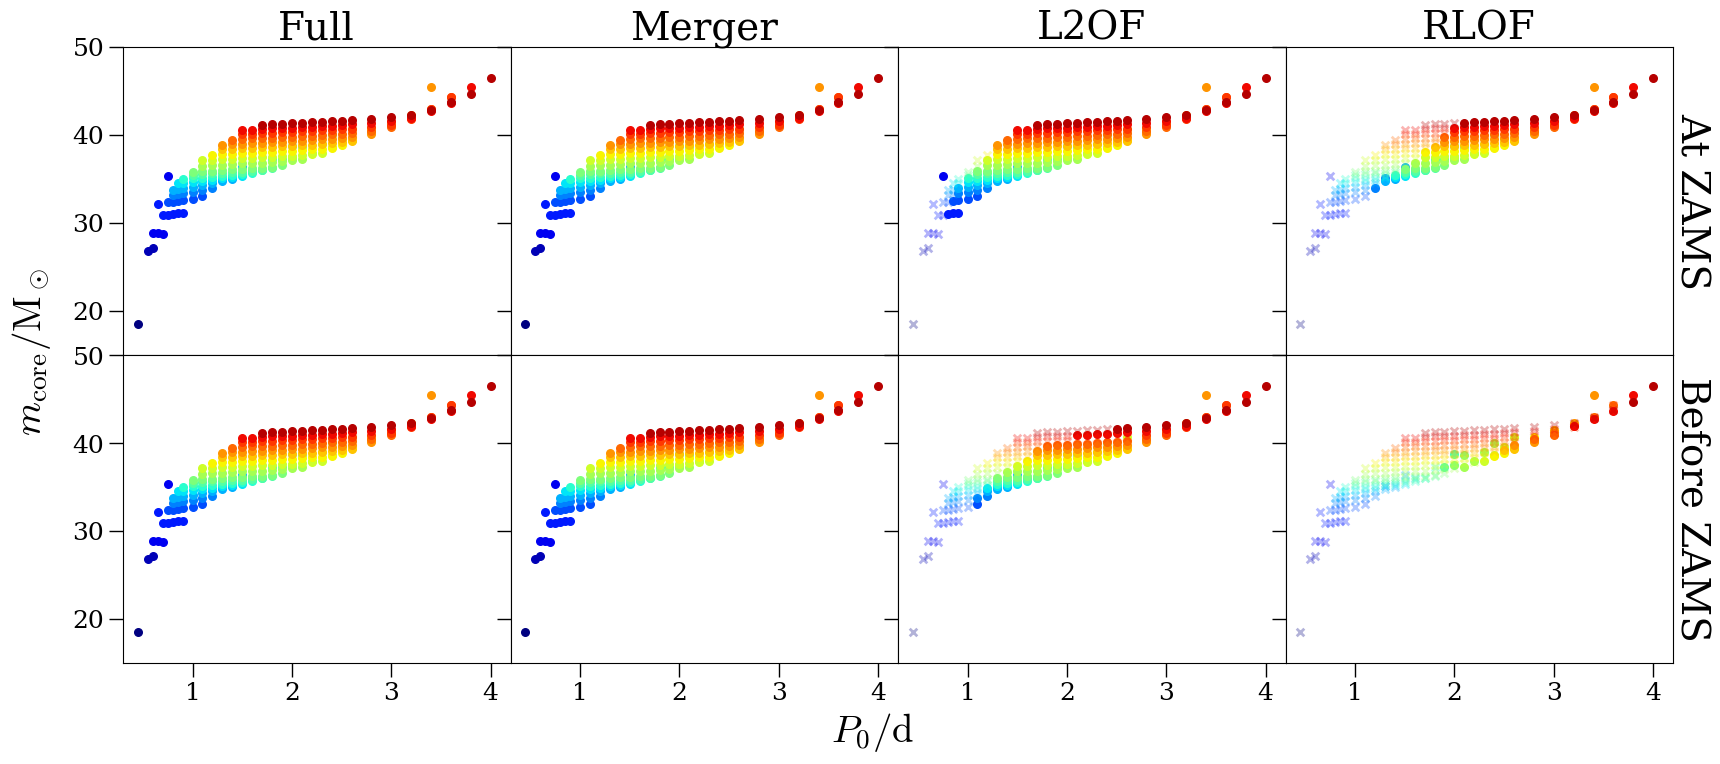

In [29]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)
plot_ps = np.linspace(0, 4, 100)

# AT ZAMS
of_when = 'zams'

of_kind = 'none'
ax = axes[0, 0]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)
ax.set_title('Full')                

of_kind = 'merger'
ax = axes[0, 1]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)
ax.set_title('Merger')                

of_kind = 'L2'
ax = axes[0, 2]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)
ax.set_title('L2OF')                

of_kind = 'RL'
ax = axes[0, 3]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)
ax.set_title('RLOF')                

# AT ZAMS
of_when = 'prezams'

of_kind = 'none'
ax = axes[1, 0]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)

of_kind = 'merger'
ax = axes[1, 1]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)

of_kind = 'L2'
ax = axes[1, 2]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)

of_kind = 'RL'
ax = axes[1, 3]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)
           
ax.set_ylim(15, 50)
ax.set_xlim(0.3, 4.2)

fig.text(0.09, 0.5, '$m_\\mathrm{core}/\\mathrm{M}_\\odot$', rotation=90, ha='right', va='center')
fig.text(0.5, 0.05, '$P_0/\\mathrm{d}$', ha='center', va='top')
axes[0, 3].text(1, 0.5, 'At ZAMS', rotation=-90, ha='left', va='center', transform=axes[0, 3].transAxes)
axes[1, 3].text(1, 0.5, 'Before ZAMS', rotation=-90, ha='left', va='center', transform=axes[1, 3].transAxes)

#ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=2, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')


#savefig(fig, 'pzams_mcore_data')

/tmp/ipykernel_427130/98124578.py:2: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0, hspace=0)
/tmp/ipykernel_427130/3646536049.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handles.append(ax.scatter([], [], c=c, marker='o', label=m_key))


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


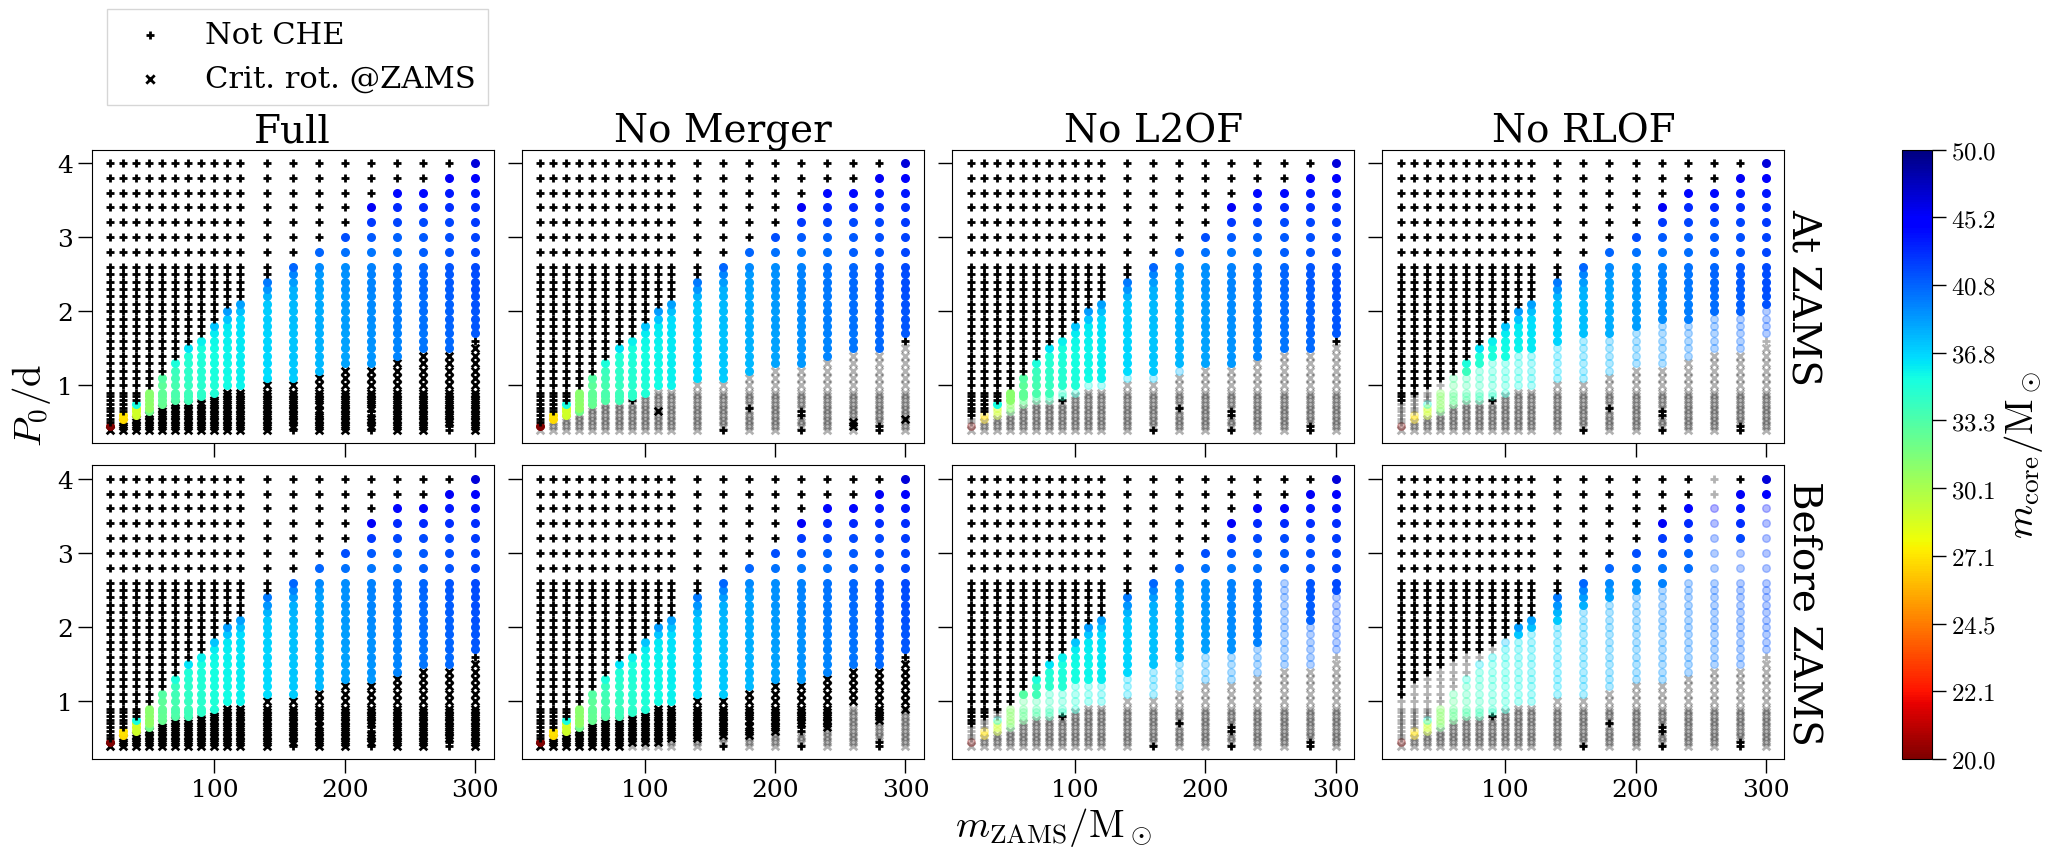

In [30]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True, layout='constrained')
fig.subplots_adjust(wspace=0, hspace=0)
plot_ps = np.linspace(0, 4, 100)

min_mcore = 20
max_mcore = 50

# AT ZAMS
of_when = 'zams'

of_kind = 'none'
ax = axes[0, 0]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)
ax.set_title('Full')                

of_kind = 'merger'
ax = axes[0, 1]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)
ax.set_title('No Merger')                

of_kind = 'L2'
ax = axes[0, 2]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)
ax.set_title('No L2OF')                

of_kind = 'RL'
ax = axes[0, 3]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)
ax.set_title('No RLOF')                

# AT ZAMS
of_when = 'prezams'

of_kind = 'none'
ax = axes[1, 0]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)

of_kind = 'merger'
ax = axes[1, 1]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)  

of_kind = 'L2'
ax = axes[1, 2]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)
             
of_kind = 'RL'
ax = axes[1, 3]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)
           
fig.text(0, 0.5, '$P_0/\\mathrm{d}$', rotation=90, ha='right', va='center')
fig.text(0.5, 0, '$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$', ha='center', va='top')
axes[0, 3].text(1, 0.5, 'At ZAMS', rotation=-90, ha='left', va='center', transform=axes[0, 3].transAxes)
axes[1, 3].text(1, 0.5, 'Before ZAMS', rotation=-90, ha='left', va='center', transform=axes[1, 3].transAxes)

sm = ScalarMappable(Normalize(vmin=np.log10(min_mcore), vmax=np.log10(max_mcore)), cm.jet_r)
cbar = fig.colorbar(sm, ax=axes[:,3], pad=0.2)
cbar.set_label('$m_\\mathrm{core}/\\mathrm{M}_\\odot$')
cbar.set_ticks(np.linspace(np.log10(min_mcore), np.log10(max_mcore), 10))
cbar.set_ticklabels([f'${10**logm:.1f}$' for logm in np.linspace(np.log10(min_mcore), np.log10(max_mcore), 10)])

handles = []
handles.append(ax.scatter([], [], marker='+', color='k', label='Not CHE'))
handles.append(ax.scatter([], [], marker='x', color='k', label='Crit. rot. @ZAMS'))
axes[0,0].legend(handles=handles, fancybox=False, loc='lower left', bbox_to_anchor=(0, 1.1))

savefig(fig, 'che_window')

## Scaled grid plot

In [33]:
min_mcore = final_mass_array[:, :, 0][np.array(final_mass_array[:, :, 9], bool)].min()
max_mcore = final_mass_array[:, :, 0][np.array(final_mass_array[:, :, 9], bool)].max()
mcore_norm = TwoSlopeNorm(vmin=min_mcore, vmax=max_mcore, vcenter=35.)
mcore_cmap = cm.seismic
nonche_c = to_rgba('darkslategrey')
crit_c = to_rgba('slategrey')

In [35]:
m_arr = np.zeros(len(mass_guide_float)+1)
p_arr = np.zeros(len(period_guide_float)+1)
mcore_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))
zams_l2of_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))

for i_m, m1 in enumerate(mass_guide_float):
    if i_m == 0:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        bin_lower_m = m1 - (bin_upper_m-m1)
    elif i_m < len(mass_guide_float)-1:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
    else:
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
        bin_upper_m = m1 + (m1-bin_lower_m)
    m_arr[i_m] = bin_lower_m
    m_arr[i_m+1] = bin_upper_m
    
    for i_p, p1 in enumerate(period_guide_float):
        if i_p == 0:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = p1 - (bin_upper_p-p1)
        elif i_p < len(period_guide_float)-1:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
        else:
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
            m2 = m1 + (m1-bin_lower_p)
        p_arr[i_p] = p0
        p_arr[i_p+1] = p2
        
        mcore = final_mass_array[i_p, i_m, 0]
        ische = final_mass_array[i_p, i_m, 9]
        iscrit = final_mass_array[i_p, i_m, 8]
        if ische:
            mcore_arr[i_m, i_p, :] = mcore_cmap(mcore_norm(mcore))
        elif iscrit: 
            mcore_arr[i_m, i_p, :] = crit_c
        else:
            mcore_arr[i_m, i_p, :] = nonche_c

        rzams = final_mass_array[i_p, i_m, 6]
        is_l2of = is_of(r=rzams, m=m1, p=p1, q=1, kind='L2')
        if is_l2of:
            zams_l2of_arr[i_m, i_p, :] = [0, 0, 0, 0]
        else:
            zams_l2of_arr[i_m, i_p, :] = 4*[nan]
            
m_arr = np.tile(m_arr, [len(period_guide_float)+1, 1]).T
p_arr = np.tile(p_arr, [len(mass_guide_float)+1, 1])

color_mcore_arr = mcore_arr
color_m_arr = m_arr
color_p_arr = p_arr

In [36]:
m_arr = np.zeros(len(mass_guide_float)+1)
p_arr = np.zeros(len(period_guide_float)+1)
mcore_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))
che_mask = np.ones((len(mass_guide_float)+1, len(period_guide_float)+1), bool)

for i_m, m1 in enumerate(mass_guide_float):
    if i_m == 0:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        bin_lower_m = m1 - (bin_upper_m-m1)
    elif i_m < len(mass_guide_float)-1:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
    else:
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
        bin_upper_m = m1 + (m1-bin_lower_m)
    m_arr[i_m] = bin_lower_m
    m_arr[i_m+1] = bin_upper_m
    
    for i_p, p1 in enumerate(period_guide_float):
        if i_p == 0:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = p1 - (bin_upper_p-p1)
        elif i_p < len(period_guide_float)-1:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
        else:
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (m0+m1)/2
            m2 = m1 + (m1-bin_lower_p)
        p_arr[i_p] = p0
        p_arr[i_p+1] = p2
        
        mcore = final_mass_array[i_p, i_m, 0]
        ische = final_mass_array[i_p, i_m, 9]
        iscrit = final_mass_array[i_p, i_m, 8]
        if ische:
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = True
        elif iscrit: 
            mcore_arr[i_m, i_p, :] = crit_c
            che_mask[i_m, i_p] = False
        else:
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = False
            
m_arr = np.tile(m_arr, [len(period_guide_float)+1, 1]).T
p_arr = np.tile(p_arr, [len(mass_guide_float)+1, 1])

hatch_crit_mcore_arr = mcore_arr
hatch_crit_m_arr = m_arr
hatch_crit_p_arr = p_arr

In [37]:
m_arr = np.zeros(len(mass_guide_float)+1)
p_arr = np.zeros(len(period_guide_float)+1)
mcore_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))
che_mask = np.ones((len(mass_guide_float)+1, len(period_guide_float)+1), bool)

for i_m, m1 in enumerate(mass_guide_float):
    if i_m == 0:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        bin_lower_m = m1 - (bin_upper_m-m1)
    elif i_m < len(mass_guide_float)-1:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
    else:
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
        bin_upper_m = m1 + (m1-bin_lower_m)
    m_arr[i_m] = bin_lower_m
    m_arr[i_m+1] = bin_upper_m
    
    for i_p, p1 in enumerate(period_guide_float):
        if i_p == 0:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = p1 - (bin_upper_p-p1)
        elif i_p < len(period_guide_float)-1:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
        else:
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (m0+m1)/2
            m2 = m1 + (m1-bin_lower_p)
        p_arr[i_p] = p0
        p_arr[i_p+1] = p2
        
        mcore = final_mass_array[i_p, i_m, 0]
        ische = final_mass_array[i_p, i_m, 9]
        iscrit = final_mass_array[i_p, i_m, 8]
        if ische:
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = True
        elif iscrit: 
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = False
        else:
            mcore_arr[i_m, i_p, :] = nonche_c
            che_mask[i_m, i_p] = False
            
m_arr = np.tile(m_arr, [len(period_guide_float)+1, 1]).T
p_arr = np.tile(p_arr, [len(mass_guide_float)+1, 1])

hatch_nonche_mcore_arr = mcore_arr
hatch_nonche_m_arr = m_arr
hatch_nonche_p_arr = p_arr

#### Unscaled version

In [38]:
nonche_hatch = '\\'
crit_hatch = '/'
l2of_hatch = 'o'

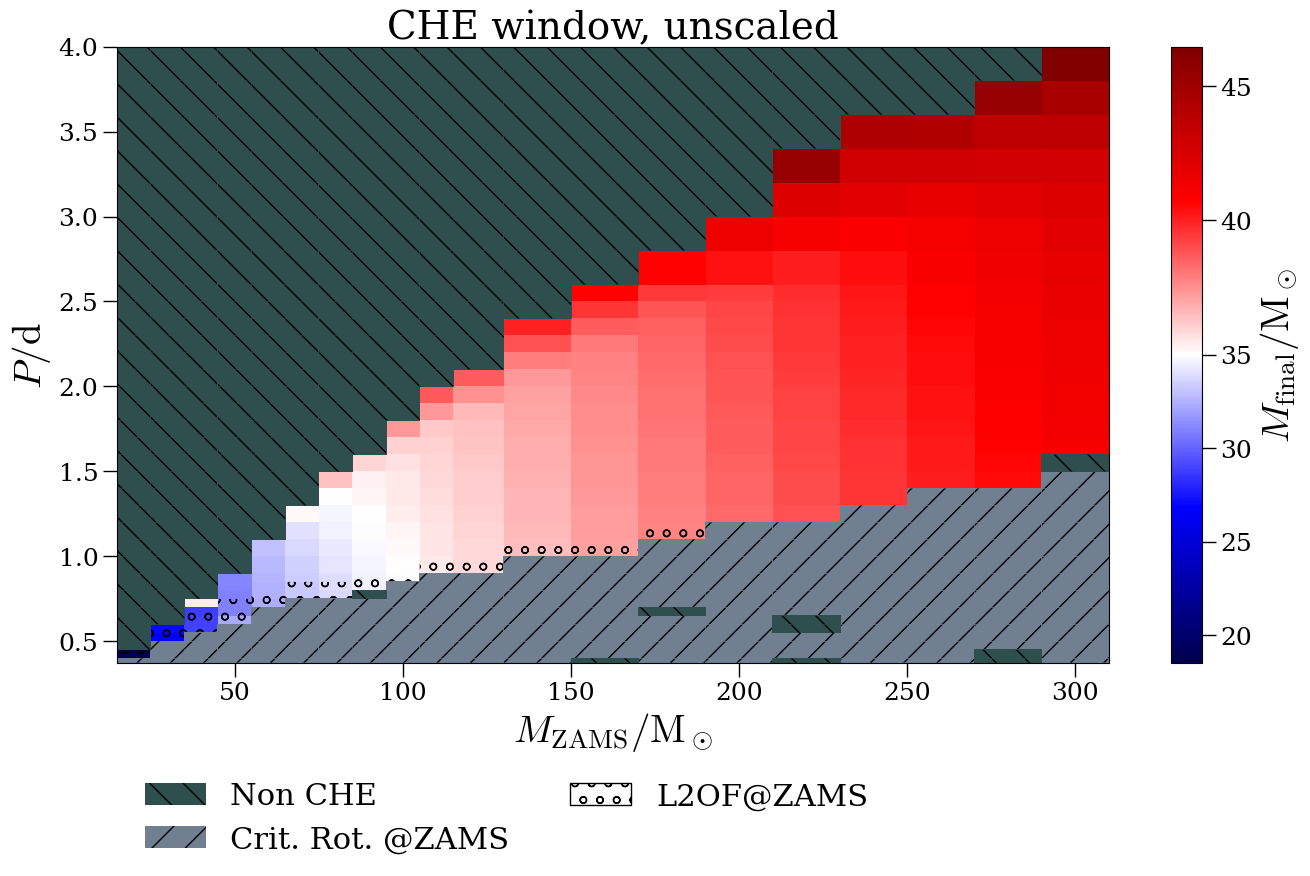

In [39]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.pcolormesh(color_m_arr, color_p_arr, color_mcore_arr, shading='flat')
ax.pcolor(color_m_arr, color_p_arr, zams_l2of_arr, hatch=l2of_hatch)
ax.pcolor(hatch_crit_m_arr, hatch_crit_p_arr, hatch_crit_mcore_arr, alpha=0., hatch=crit_hatch)
ax.pcolor(hatch_nonche_m_arr, hatch_nonche_p_arr, hatch_nonche_mcore_arr, alpha=0., hatch=nonche_hatch)

ax.set_xlabel('$M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_ylabel('$P/\\mathrm{d}$')

sm = ScalarMappable(norm=mcore_norm, cmap=mcore_cmap)
cb = fig.colorbar(sm, ax=ax)
cb.set_label('$M_\\mathrm{final}/\\mathrm{M}_\\odot$')

handles = []
handles.append(Patch(facecolor=nonche_c, hatch=nonche_hatch, label='Non CHE'))
handles.append(Patch(facecolor=crit_c, hatch=crit_hatch, label='Crit. Rot. @ZAMS'))
handles.append(Patch(facecolor='w', hatch=l2of_hatch, label='L2OF@ZAMS', edgecolor='k'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(0, -0.15), ncol=2)

ax.set_title('CHE window, unscaled')

savefig(fig, 'che_window_unscaled')

#### Scaled version

To get a better grasp on how populated the CHE window, we would like to re-scale the plot axes by appropriate probability distributions. For the mass (x) axis, we use a Salpeter IMF,

In [40]:
def mass_forward(m):
    return m**-2.35

def mass_inverse(m):
    return m**(-1/2.35)

For the orbital period (y) axis, we assume a log-uniform ditribution,

/tmp/ipykernel_427130/1587637377.py:2: RuntimeWarning: divide by zero encountered in power
  return m**-2.35
/tmp/ipykernel_427130/1587637377.py:2: RuntimeWarning: divide by zero encountered in power
  return m**-2.35


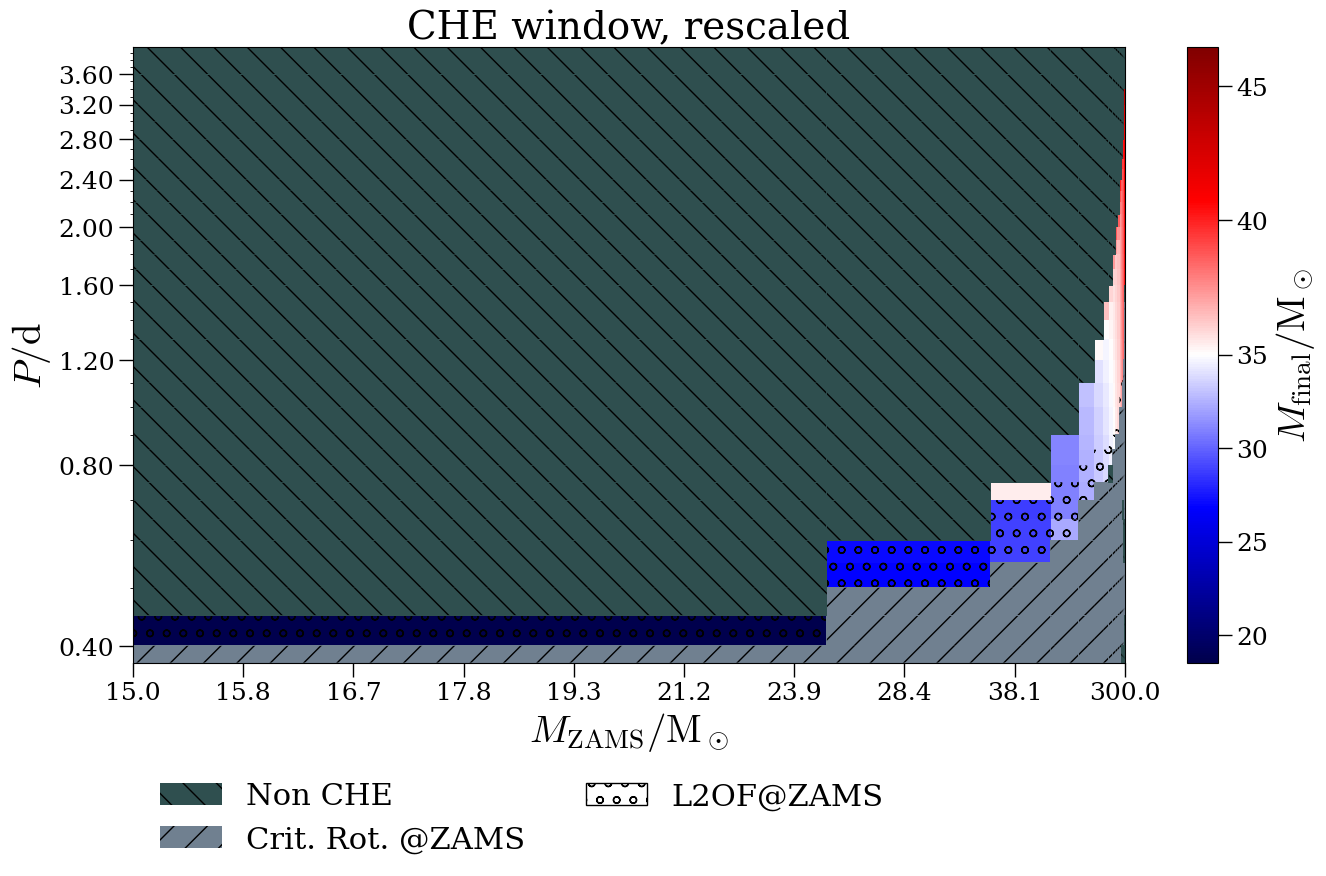

In [41]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.pcolormesh(color_m_arr, color_p_arr, color_mcore_arr, shading='flat')
ax.pcolor(color_m_arr, color_p_arr, zams_l2of_arr, hatch=l2of_hatch)
ax.pcolor(hatch_crit_m_arr, hatch_crit_p_arr, hatch_crit_mcore_arr, alpha=0., hatch=crit_hatch)
ax.pcolor(hatch_nonche_m_arr, hatch_nonche_p_arr, hatch_nonche_mcore_arr, alpha=0., hatch=nonche_hatch)

ax.set_xlabel('$M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_ylabel('$P/\\mathrm{d}$')

sm = ScalarMappable(norm=mcore_norm, cmap=mcore_cmap)
cb = fig.colorbar(sm, ax=ax)
cb.set_label('$M_\\mathrm{final}/\\mathrm{M}_\\odot$')

handles = []
handles.append(Patch(facecolor=nonche_c, hatch=nonche_hatch, label='Non CHE'))
handles.append(Patch(facecolor=crit_c, hatch=crit_hatch, label='Crit. Rot. @ZAMS'))
handles.append(Patch(facecolor='w', hatch=l2of_hatch, label='L2OF@ZAMS', edgecolor='k'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(0, -0.15), ncol=2)

ax.set_yscale('log')
ax.set_xscale('function', functions=(mass_forward, mass_inverse))
ax.set_xticks([mass_inverse(x) for x in np.linspace(mass_forward(15), mass_forward(300), 10)])

ax.set_xlim(15, 310)
ax.invert_xaxis()

ax.set_yticks(np.arange(0.4, 4, 0.4))
ax.set_yticklabels([f'{p:.2f}' for p in np.arange(0.4, 4, 0.4)])
ax.set_yticks(np.arange(0.4, 4, 0.1), minor=True)
ax.set_yticklabels([], minor=True)

ax.set_title('CHE window, rescaled')

savefig(fig, 'che_window_rescaled')

/tmp/ipykernel_427130/1587637377.py:2: RuntimeWarning: divide by zero encountered in power
  return m**-2.35
/tmp/ipykernel_427130/1587637377.py:2: RuntimeWarning: divide by zero encountered in power
  return m**-2.35


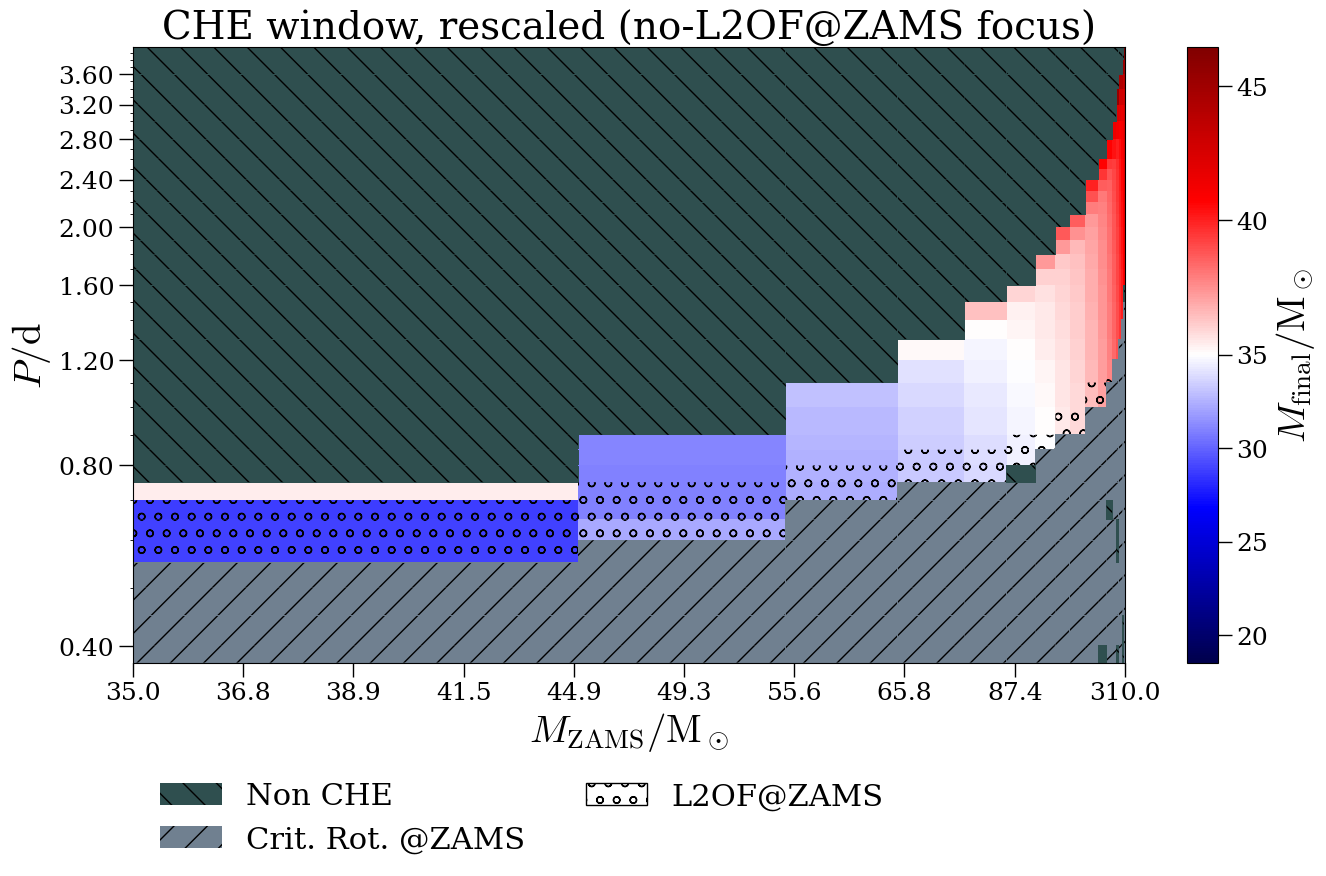

In [43]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.pcolormesh(color_m_arr, color_p_arr, color_mcore_arr, shading='flat')
ax.pcolor(color_m_arr, color_p_arr, zams_l2of_arr, hatch=l2of_hatch)
ax.pcolor(hatch_crit_m_arr, hatch_crit_p_arr, hatch_crit_mcore_arr, alpha=0., hatch=crit_hatch)
ax.pcolor(hatch_nonche_m_arr, hatch_nonche_p_arr, hatch_nonche_mcore_arr, alpha=0., hatch=nonche_hatch)

ax.set_xlabel('$M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_ylabel('$P/\\mathrm{d}$')

sm = ScalarMappable(norm=mcore_norm, cmap=mcore_cmap)
cb = fig.colorbar(sm, ax=ax)
cb.set_label('$M_\\mathrm{final}/\\mathrm{M}_\\odot$')

handles = []
handles.append(Patch(facecolor=nonche_c, hatch=nonche_hatch, label='Non CHE'))
handles.append(Patch(facecolor=crit_c, hatch=crit_hatch, label='Crit. Rot. @ZAMS'))
handles.append(Patch(facecolor='w', hatch=l2of_hatch, label='L2OF@ZAMS', edgecolor='k'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(0, -0.15), ncol=2)

ax.set_yscale('log')
ax.set_xscale('function', functions=(mass_forward, mass_inverse))
ax.set_xticks([mass_inverse(x) for x in np.linspace(mass_forward(35), mass_forward(310), 10)])

ax.set_xlim(35, 310)
ax.invert_xaxis()

ax.set_yticks(np.arange(0.4, 4, 0.4))
ax.set_yticklabels([f'{p:.2f}' for p in np.arange(0.4, 4, 0.4)])
ax.set_yticks(np.arange(0.4, 4, 0.1), minor=True)
ax.set_yticklabels([], minor=True)

ax.set_title('CHE window, rescaled (no-L2OF@ZAMS focus)')

savefig(fig, 'che_window_rescaled_no_l2of')

The thin strip of $~25

## Interpolators

In [44]:
interpolator_dict = dict()

for i, m in enumerate(mass_guide_float):
    m_key = mass_guide_str[i]
    p_arr = period_guide_float   
    y_arr = final_mass_array[:, i, 0] 
    r_arr = final_mass_array[:, i, 6] 

    mask = np.array(final_mass_array[:, i, 9], bool)
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]
            
    if m_key in ['50.0']:
        y_arr = y_arr[1:]
        p_arr = p_arr[1:]
        r_arr = r_arr[1:]
        
    if m_key in ['40.0', '220.0']:
        y_arr = y_arr[:-1]
        p_arr = p_arr[:-1]
        r_arr = r_arr[:-1]
        
    mask = []
    for p0, rzams in zip(p_arr, r_arr):
        isof = is_of(rzams, float(m_key), p0, 1, kind='L2')
        if isof:
            mask.append(False)
        else:
            mask.append(True)
            
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]
    
    if len(y_arr) == 0:
        y_arr = [nan]
        p_arr = [1]
        r_arr = [1]
    
    interpolator = interp1d(
        x=p_arr,
        y=y_arr,
        kind='linear',
        bounds_error=False,
        fill_value=nan
        )

    interpolator_dict[m_key] = interpolator     
    
l2_pzams_mcore_interpolator_dict = interpolator_dict

/tmp/ipykernel_427130/920947829.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(period_guide_float[che_mask], final_mass_array[:,i,0][che_mask], marker='o', c=c, zorder=1, label=m_key, s=20, alpha=0.5)
/tmp/ipykernel_427130/920947829.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(period_guide_float[~che_mask], final_mass_array[:,i,3][~che_mask], marker='x', c=c, zorder=2)
The PostScript backen

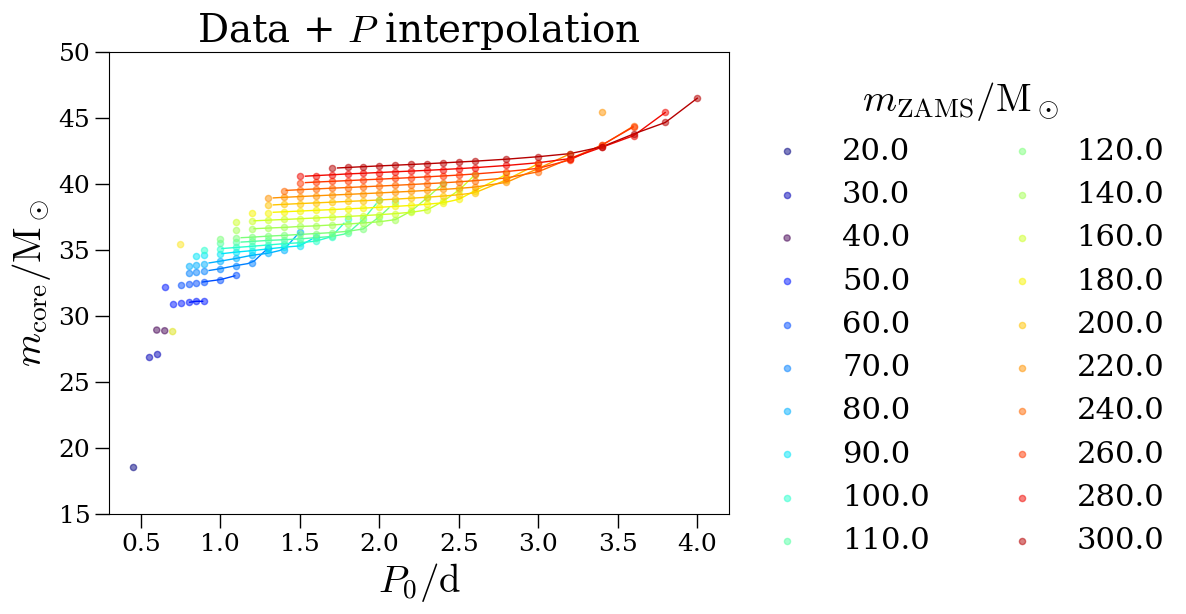

In [45]:
fig, ax = plt.subplots(figsize=(8, 6))
interpolator_dict = l2_pzams_mcore_interpolator_dict

for i, m_key in enumerate(mass_guide_str):
    c = cm.jet(i/len(mass_guide_str))
    interpolator = interpolator_dict[m_key]
    plot_ps = np.linspace(0, 4, 100)
    che_mask = np.array(final_mass_array[:,i,9], bool)
    ax.scatter(period_guide_float[che_mask], final_mass_array[:,i,0][che_mask], marker='o', c=c, zorder=1, label=m_key, s=20, alpha=0.5)
    ax.scatter(period_guide_float[~che_mask], final_mass_array[:,i,3][~che_mask], marker='x', c=c, zorder=2)
    ax.plot(plot_ps, interpolator(plot_ps), c=c, zorder=0, lw=1)
    
ax.set_ylim(15, 50)
ax.set_xlim(0.3, 4.2)

ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$m_\\mathrm{core}/\\mathrm{M}_\\odot$')

ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=2, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_title('Data + $P$ interpolation')

savefig(fig, 'pzams_mcore_data')

In [46]:
def l2_mzams_mcore_interpolator(m_zams, p_zams):
    ip_m_cores = []
    for m_key in mass_guide_str:
        interpolator = l2_pzams_mcore_interpolator_dict[m_key]
        ip_m_cores.append(interpolator(p_zams))
    
    interpolator = interp1d(
        x=mass_guide_float,
        y=ip_m_cores,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )
    
    m_core = interpolator(m_zams)
    
    return m_core  

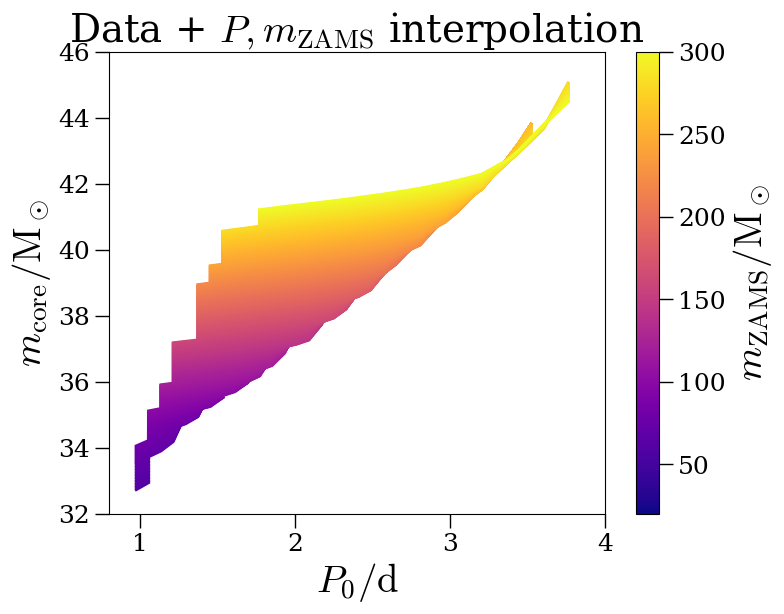

In [47]:
fig, ax = plt.subplots(figsize=(8, 6))
interpolator = l2_mzams_mcore_interpolator
cmap = cm.plasma

test_masses = np.linspace(20, 300, 500)
test_periods = np.linspace(0.1, 4)

for i, m in enumerate(test_masses):
    c = cmap(i/len(test_masses))
    m_cores = [interpolator(m, p) for p in test_periods]
    ax.plot(test_periods, m_cores, c=c, lw=2, label=f'${m:.1f}$')
    
ax.set_ylim(32, 46)
ax.set_xlim(0.8, 4)

ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$m_\\mathrm{core}/\\mathrm{M}_\\odot$')

#ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
sm = ScalarMappable(norm=Normalize(vmin=min(test_masses), vmax=max(test_masses)), cmap=cmap)
cb = fig.colorbar(mappable=sm, ax=ax)
cb.set_label('$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

ax.set_title('Data + $P,m_\\mathrm{ZAMS}$ interpolation')

savefig(fig, 'pzams_mcore_ip')

In [48]:
interpolator_dict = dict()

for i, m in enumerate(mass_guide_float):
    m_key = mass_guide_str[i]
    p_arr = period_guide_float   
    y_arr = final_mass_array[:, i, 6] 
    r_arr = final_mass_array[:, i, 6] 
    
    mask = np.array(final_mass_array[:, i, 9], bool)
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]

    if m_key in ['280.0', '220.0', '160.0', '50.0', '80.0']:
        p_arr = p_arr[1:]
        y_arr = y_arr[1:]
        r_arr = r_arr[1:]
 
    mask = []
    for p0, rzams in zip(p_arr, r_arr):
        isof = is_of(rzams, float(m_key), p0, 1, kind='L2')
        if isof:
            mask.append(False)
        else:
            mask.append(True)
    
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]
    
    if len(y_arr) == 0:
        y_arr = [nan]
        p_arr = [1]
        r_arr = [1]
    
    interpolator = interp1d(
        x=p_arr,
        y=y_arr,
        kind='linear',
        bounds_error=False,
        fill_value=nan
        )

    interpolator_dict[m_key] = interpolator     
    
l2_pzams_rzams_interpolator_dict = interpolator_dict

/tmp/ipykernel_427130/4193244287.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(period_guide_float[che_mask], final_mass_array[:,i,6][che_mask], marker='o', c=c, zorder=1, s=20, alpha=0.5)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


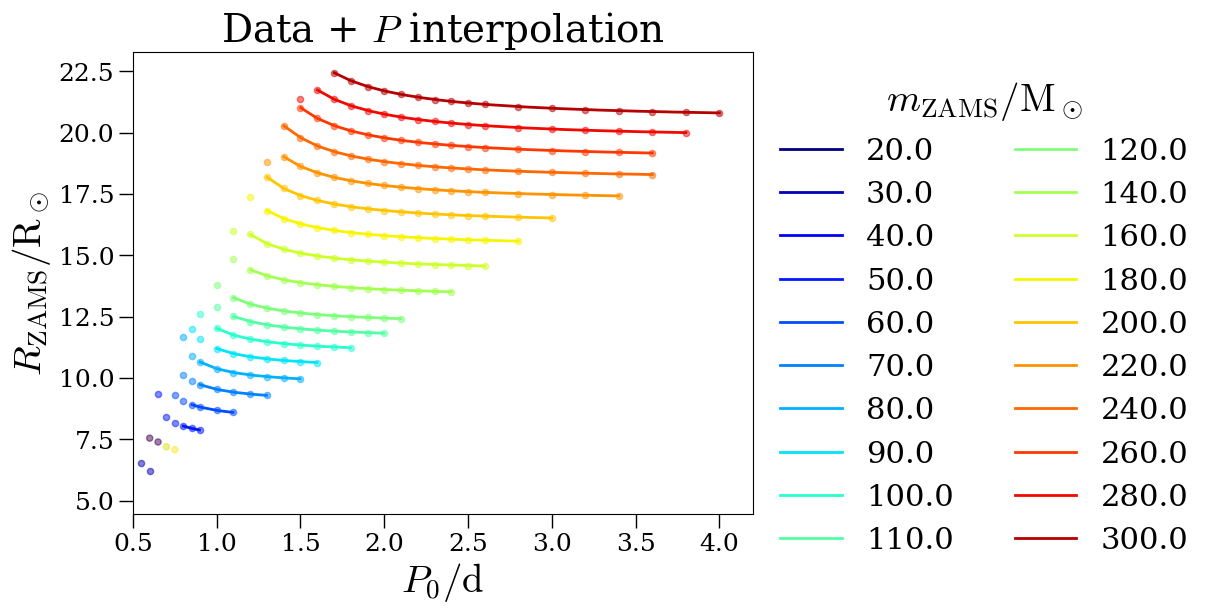

In [49]:
fig, ax = plt.subplots(figsize=(8, 6))
interpolator_dict = l2_pzams_rzams_interpolator_dict

for i, m_key in enumerate(mass_guide_str):
    c = cm.jet(i/len(mass_guide_str))
    interpolator = interpolator_dict[m_key]
    plot_ps = np.linspace(0, 4, 1000)
    che_mask = np.array(final_mass_array[:,i,9], bool)
    ax.scatter(period_guide_float[che_mask], final_mass_array[:,i,6][che_mask], marker='o', c=c, zorder=1, s=20, alpha=0.5)
    #ax.scatter(period_guide_float[~che_mask], final_mass_array[:,i,6][~che_mask], marker='x', c=c, zorder=2)
    ax.plot(plot_ps, interpolator(plot_ps), c=c, label=m_key, zorder=0)
    
#ax.set_ylim(20, 40)
ax.set_xlim(0.5, 4.2)

ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$R_\\mathrm{ZAMS}/\\mathrm{R}_\\odot$')

ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=2, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_title('Data + $P$ interpolation')

savefig(fig, 'pzams_rzams_data')

In [52]:
def l2_mzams_rzams_interpolator(m_zams, p_zams):
    ip_m_cores = []
    for m_key in mass_guide_str:
        interpolator = l2_pzams_rzams_interpolator_dict[m_key]
        ip_m_cores.append(interpolator(p_zams))
    
    interpolator = interp1d(
        x=mass_guide_float,
        y=ip_m_cores,
        kind='linear',
        bounds_error=False,
        fill_value=nan
    )
    
    m_core = interpolator(m_zams)
    
    return m_core      

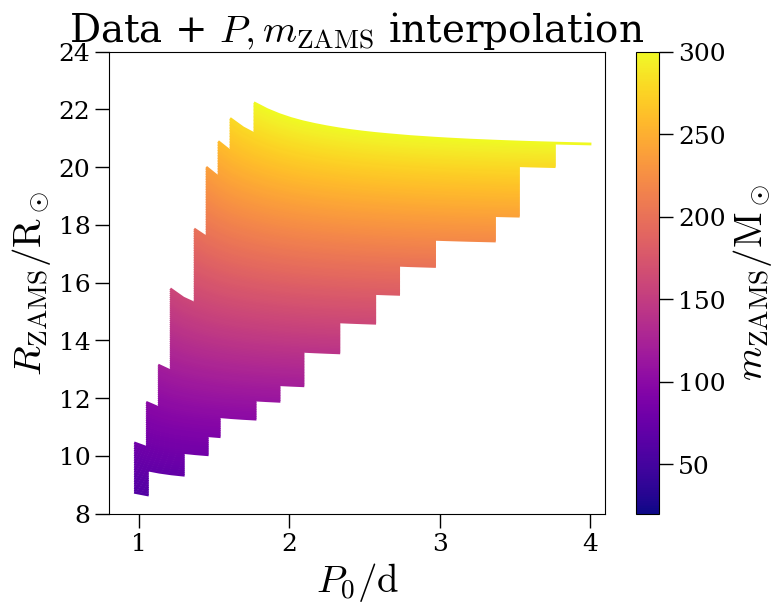

In [53]:
fig, ax = plt.subplots(figsize=(8, 6))
interpolator = l2_mzams_rzams_interpolator
cmap = cm.plasma

test_masses = np.linspace(20, 300, 300)
test_periods = np.linspace(0.1, 4)

for i, m in enumerate(test_masses):
    c = cmap(i/len(test_masses))
    m_cores = [interpolator(m, p) for p in test_periods]
    ax.plot(test_periods, m_cores, c=c, lw=2, label=f'${m:.1f}$')
    
ax.set_ylim(8, 24)
ax.set_xlim(0.8, 4.1)

ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$R_\\mathrm{ZAMS}/\\mathrm{R}_\\odot$')

#ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
sm = ScalarMappable(norm=Normalize(vmin=min(test_masses), vmax=max(test_masses)), cmap=cmap)
cb = fig.colorbar(mappable=sm, ax=ax)
cb.set_label('$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

ax.set_title('Data + $P,m_\\mathrm{ZAMS}$ interpolation')

savefig(fig, 'pzams_rzams_ip')

### Core mass distribution

In [55]:
res = int(1e8)
min_m = 20
max_m = 300
min_p = 0.1
max_p = 4

sample_masses = np.linspace(min_m, max_m, res)
sample_probs = sample_masses**-2.3/np.sum(sample_masses**-2.3)
sample_masses = np.random.choice(sample_masses, p=sample_probs, size=int(res/100))

sample_periods = np.linspace(np.log10(min_p), np.log10(max_p), res)
sample_probs = np.ones(res)/res
sample_periods = 10.**np.random.choice(sample_periods, p=sample_probs, size=int(res/100))

sample_zams_rs = np.array([l2_mzams_rzams_interpolator(m, p) for m, p in zip(sample_masses, sample_periods)])

sample_mcores = np.zeros(int(res/100))

sample_ = np.array([sample_masses, sample_periods, sample_zams_rs, sample_mcores]).T

KeyboardInterrupt: 

In [56]:
def set_mcores(sample):
    for i, star in enumerate(sample):
        r = star[2]
        isof = is_of(r=r, m=star[0], p=star[1], q=1, kind='L2')
        if isof:
            mcore = nan
        else:
            mcore = l2_mzams_mcore_interpolator(star[0], star[1])
        sample[i, 3] = mcore
    return sample

In [59]:
def draw_mass_sample(
    res=int(1e8),
    min_m=20,
    max_m=300,
    min_p=0.1,
    max_p=4,
    min_mfinal=20,
    max_mfinal=50,
    mfinal_bin_width=0.2
):
    sample_masses = np.linspace(min_m, max_m, res)
    sample_probs = sample_masses**-2.3/np.sum(sample_masses**-2.3)
    sample_masses = np.random.choice(sample_masses, p=sample_probs, size=int(res/100))

    sample_periods = np.linspace(np.log10(min_p), np.log10(max_p), res)
    sample_probs = np.ones(res)/res
    sample_periods = 10.**np.random.choice(sample_periods, p=sample_probs, size=int(res/100))

    sample_zams_rs = np.array([l2_mzams_rzams_interpolator(m, p) for m, p in zip(sample_masses, sample_periods)])

    sample_mcores = np.zeros(int(res/100))

    sample_ = np.array([sample_masses, sample_periods, sample_zams_rs, sample_mcores]).T
    zams_l2of_sample = set_mcores(sample_).copy()
    
    mass_draw = zams_l2of_sample[:, 3]
    mass_draw = mass_draw[~np.isnan(mass_draw)]

    bins = np.arange(min_mfinal, max_mfinal+mfinal_bin_width, mfinal_bin_width)
    hist, bins = np.histogram(mass_draw, density=True, bins=bins)
    centers = np.array([(bin0+bin1)/2 for bin0, bin1 in zip(bins[:-1], bins[1:])])
    mode = centers[np.argmax(hist)]
    
    return zams_l2of_sample, mode

In [60]:
from multiprocessing import Pool
from scipy.stats import mode

In [61]:
result = draw_mass_sample(res=int(1e8))

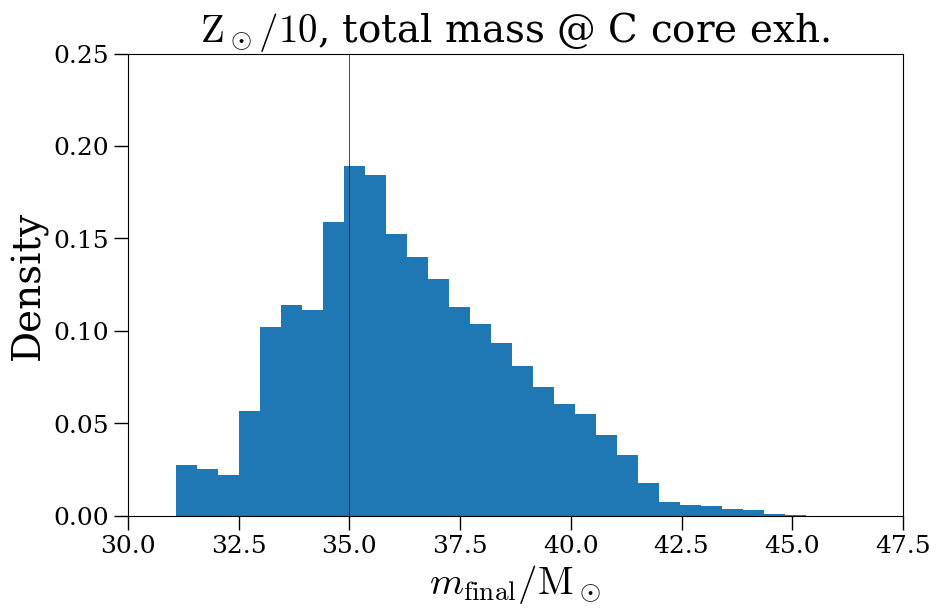

In [64]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(result[0][:,3], density=True, bins=30)

ax.vlines(35, 0, 0.3, color='k', lw=0.5)
ax.set_ylim(0, 0.25)
ax.set_xlim(30, 45)
ax.set_xticks(np.arange(30, 50, 2.5))

ax.set_ylabel('Density')
ax.set_xlabel('$m_\\mathrm{final}/\mathrm{M}_\odot$')
ax.set_title('$\\mathrm{Z}_\\odot/10$, total mass @ C core exh.')

savefig(fig, 'mfinal_distr_01_zsun_clean')

Text(0.98, 0.98, 'Stopping condition: central_c12<=1e-6\nSome models start core Ne burning')

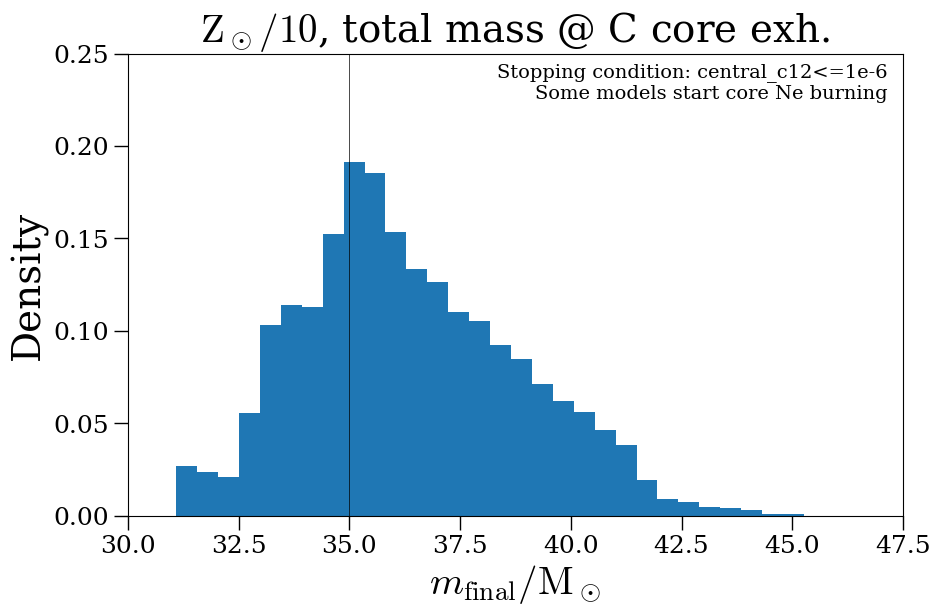

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(result[0][:,3], density=True, bins=30)

ax.vlines(35, 0, 0.3, color='k', lw=0.5)
ax.set_ylim(0, 0.25)
ax.set_xlim(30, 45)
ax.set_xticks(np.arange(30, 50, 2.5))

ax.set_ylabel('Density')
ax.set_xlabel('$m_\\mathrm{final}/\mathrm{M}_\odot$')
ax.set_title('$\\mathrm{Z}_\\odot/10$, total mass @ C core exh.')

note = '\n'.join(('Stopping condition: central_c12<=1e-6',
                  'Some models start core Ne burning'))
ax.text(0.98, 
        0.98, 
        note,
        transform=ax.transAxes,
        ha='right',
        va='top',
        fontsize=14
        )


In [57]:
n_cores = 36
process_pool = Pool(n_cores)
results = process_pool.map(draw_mass_sample, [int(1e8)]*10)

KeyboardInterrupt: 

(0.0, 0.25)

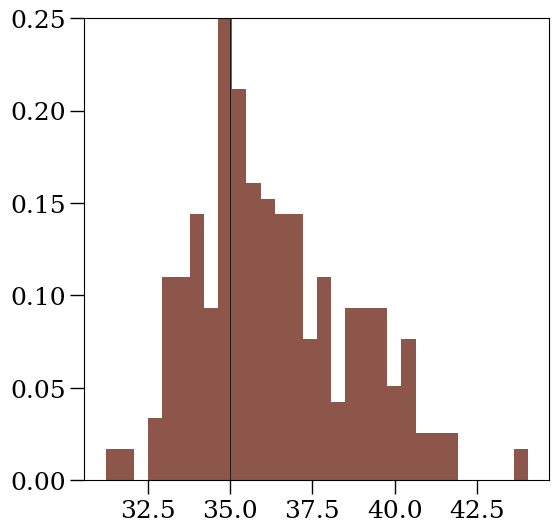

In [56]:
fig, ax = plt.subplots(figsize=(6,6))

for draw, mode in results:
    ax.hist(draw[:,3], density=True, bins=30)

ax.vlines(35, 0, 0.3, color='k', lw=0.5)
ax.set_ylim(0, 0.25)


In [179]:
import pickle as pkl
np.save('31mcore_sample.npy', sample_)
with open('31mzams_mcore_interpolator.pkl', 'wb') as f:
    pkl.dump(l2_mzams_mcore_interpolator, f)